<a href="https://colab.research.google.com/github/joseluis031/Red_neuronal_mas_poderosa/blob/main/Red_neuronal_mas_poderosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Abrimos el dataset Proteins que contiene 1113 grafos que representan proteínas

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 39
Number of features: 3
Number of classes: 2


Done!


Dibujamos uno de ellos

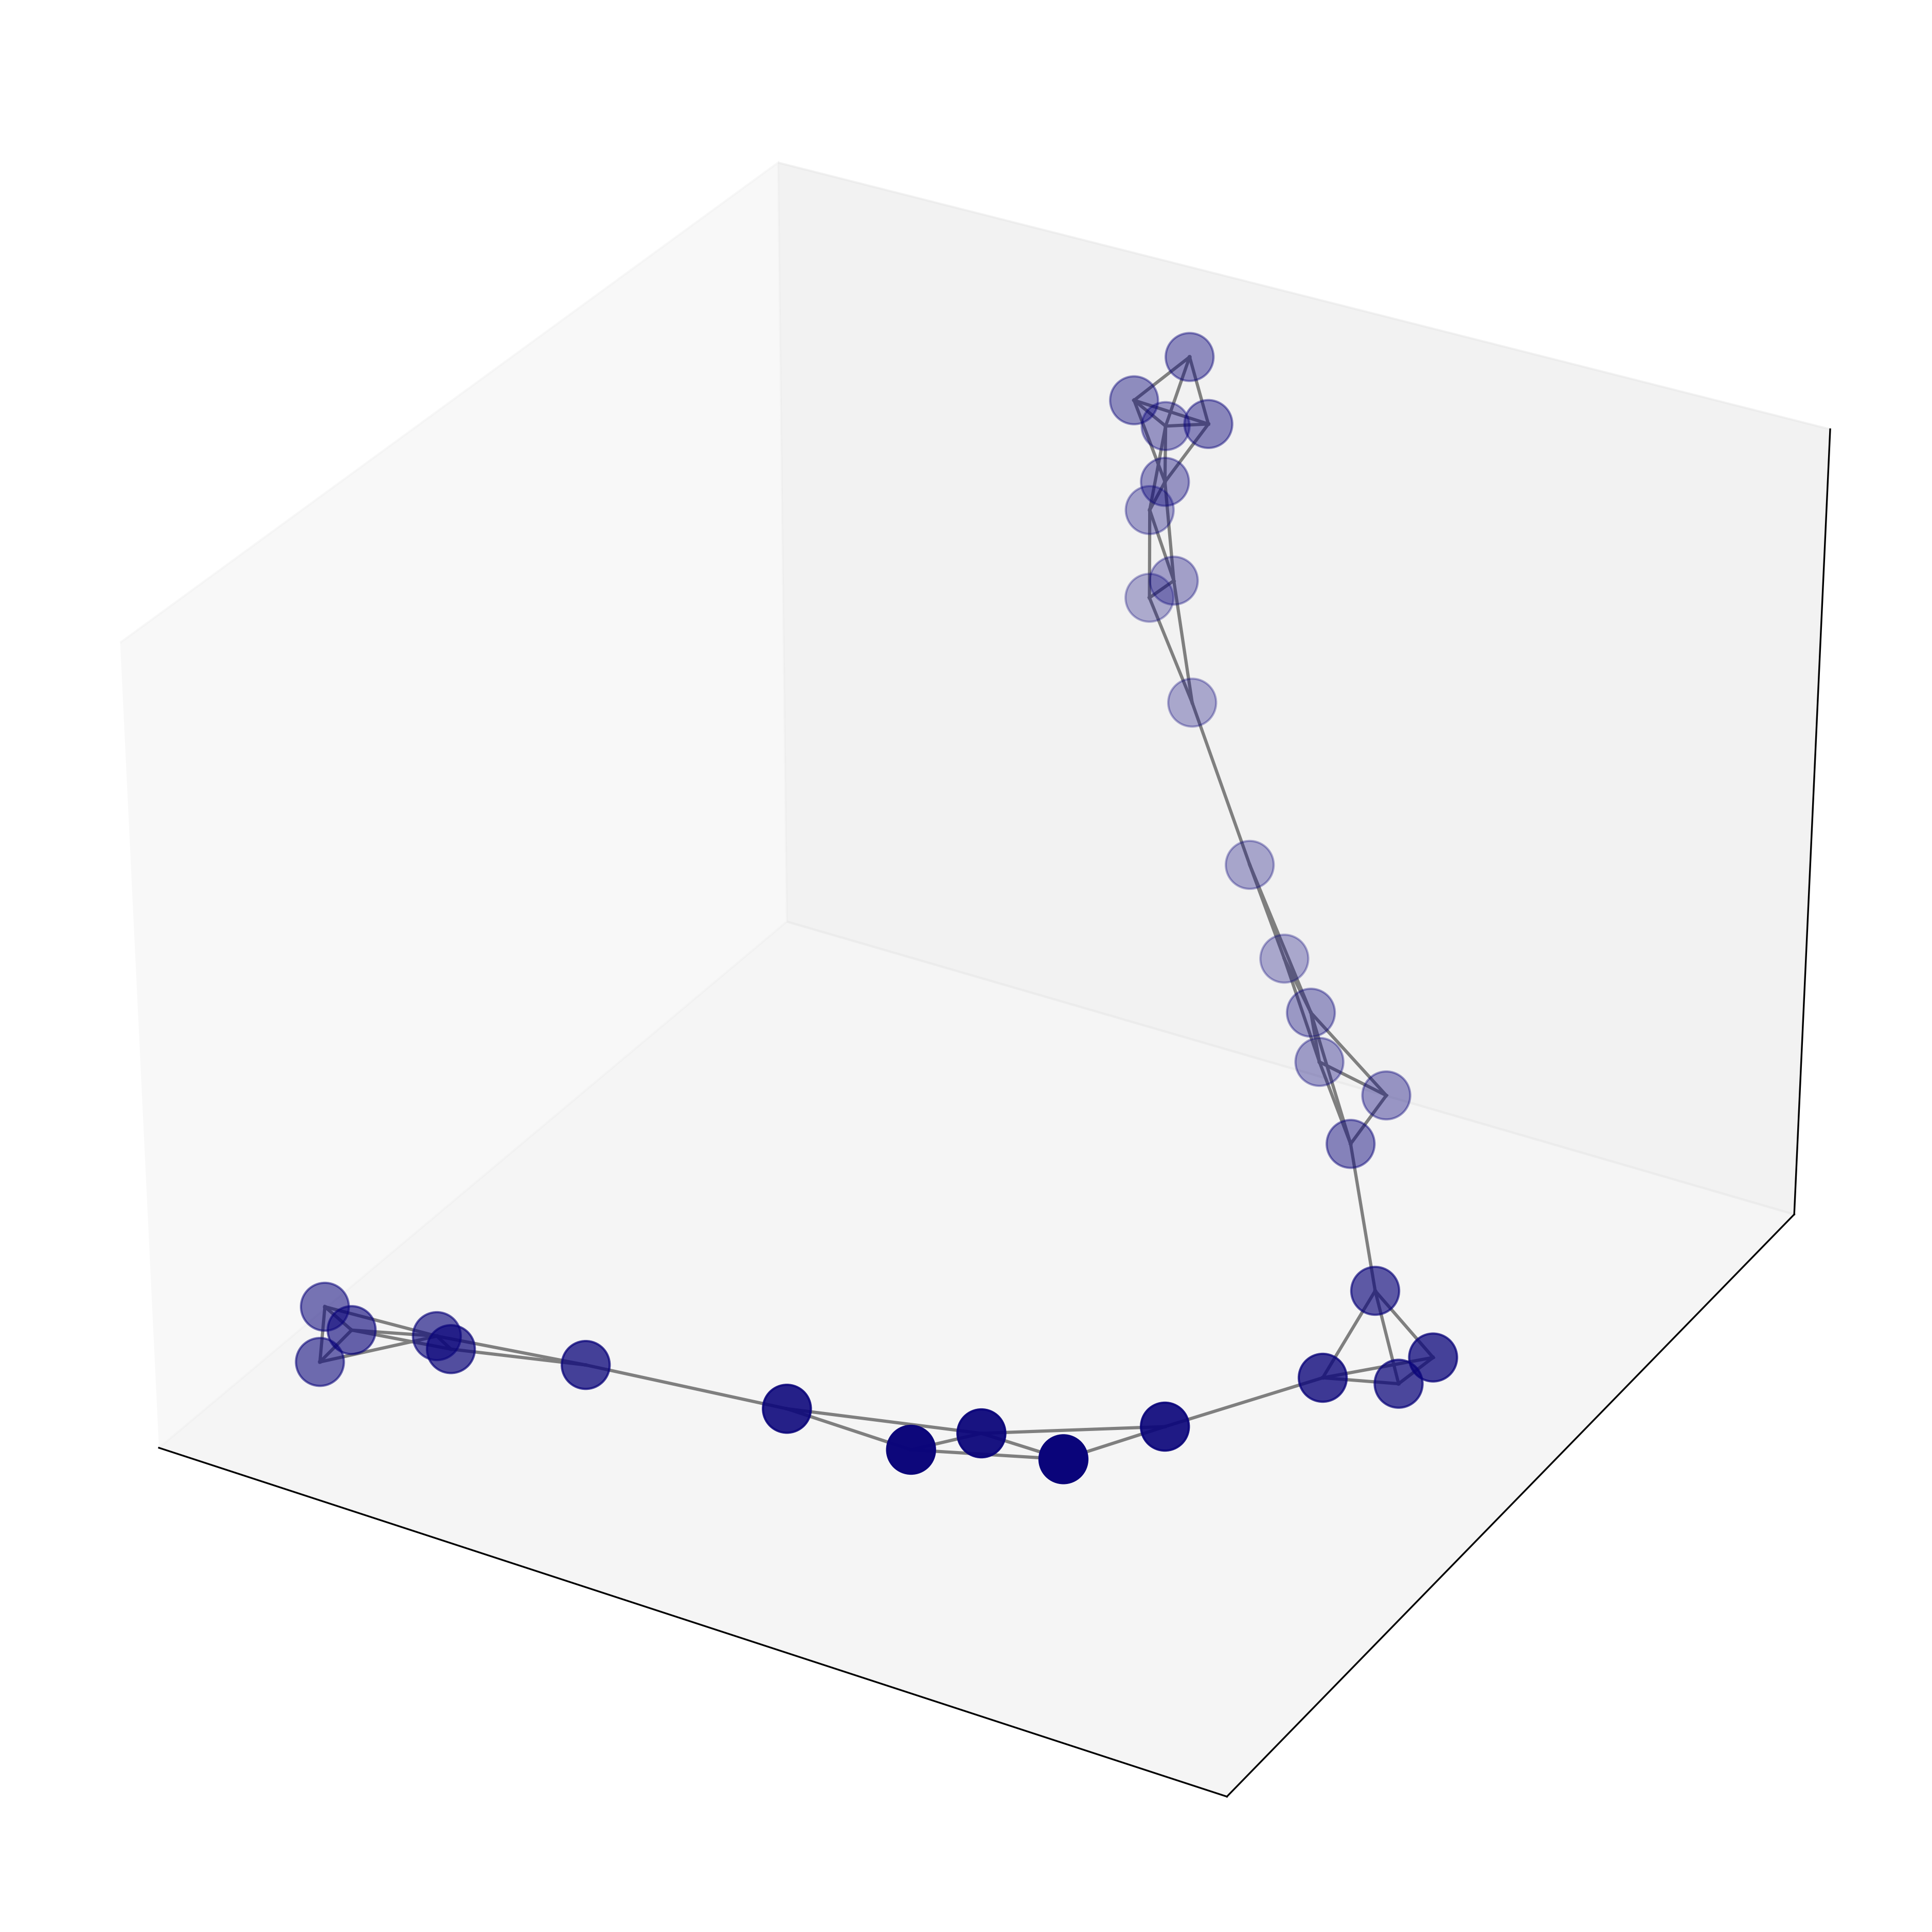

In [3]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

G = to_networkx(dataset[2], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
plt.show()

Observamos sus mini-lotes

In [5]:
from torch_geometric.loader import DataLoader
# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')


Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 8244], x=[2170, 3], y=[64], batch=[2170], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 8208], x=[2172, 3], y=[64], batch=[2172], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 8794], x=[2398, 3], y=[64], batch=[2398], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 10144], x=[2829, 3], y=[64], batch=[2829], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 8240], x=[2195, 3], y=[64], batch=[2195], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 8838], x=[2287, 3], y=[64], batch=[2287], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 8782], x=[2358, 3], y=[64], batch=[2358], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 10624], x=[2968, 3], y=[64], batch=[2968], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 9528], x=[2498, 3], y=[64], batch=[2498], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 7802], x=[2100, 3], y=[64], bat

GIN en PyTorch geométrico

In [6]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)

        return hG, F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h, F.log_softmax(h, dim=1)

gcn = GCN(dim_h=32)
gin = GIN(dim_h=32)




def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 100
    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
          optimizer.zero_grad()
          _, out = model(data.x, data.edge_index, data.batch)
          loss = criterion(out, data.y)
          total_loss += loss / len(loader)
          acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
          loss.backward()
          optimizer.step()

          # Validation
          val_loss, val_acc = test(model, val_loader)

    # Print metrics every 10 epochs
    if(epoch % 10 == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')

    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

    return model

@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
          _, out = model(data.x, data.edge_index, data.batch)
          loss += criterion(out, data.y) / len(loader)
          acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = train(gcn, train_loader)
gin = train(gin, train_loader)

from torch_geometric.loader import DataLoader
# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Epoch 100 | Train Loss: 0.68 | Train Acc: 58.61% | Val Loss: 0.64 | Val Acc: 69.20%
Test Loss: 0.68 | Test Acc: 57.03%
Epoch 100 | Train Loss: 0.51 | Train Acc: 75.37% | Val Loss: 0.53 | Val Acc: 75.02%
Test Loss: 0.53 | Test Acc: 72.92%
Training set   = 890 graphs
Validation set = 111 graphs
Test set       = 112 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 8956], x=[2429, 3], y=[64], batch=[2429], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 10492], x=[2895, 3], y=[64], batch=[2895], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 9750], x=[2612, 3], y=[64], batch=[2612], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 8682], x=[2376, 3], y=[64], batch=[2376], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 12828], x=[3583, 3], y=[64], batch=[3583], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 9058], x=[2290, 3], y=[64], batch=[2290], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 9080], x=[2416, 3], y=[64], batch=[2416], ptr=[65])
 - Subgraph 7: Da

Visualizamos las proteínas clasificadas

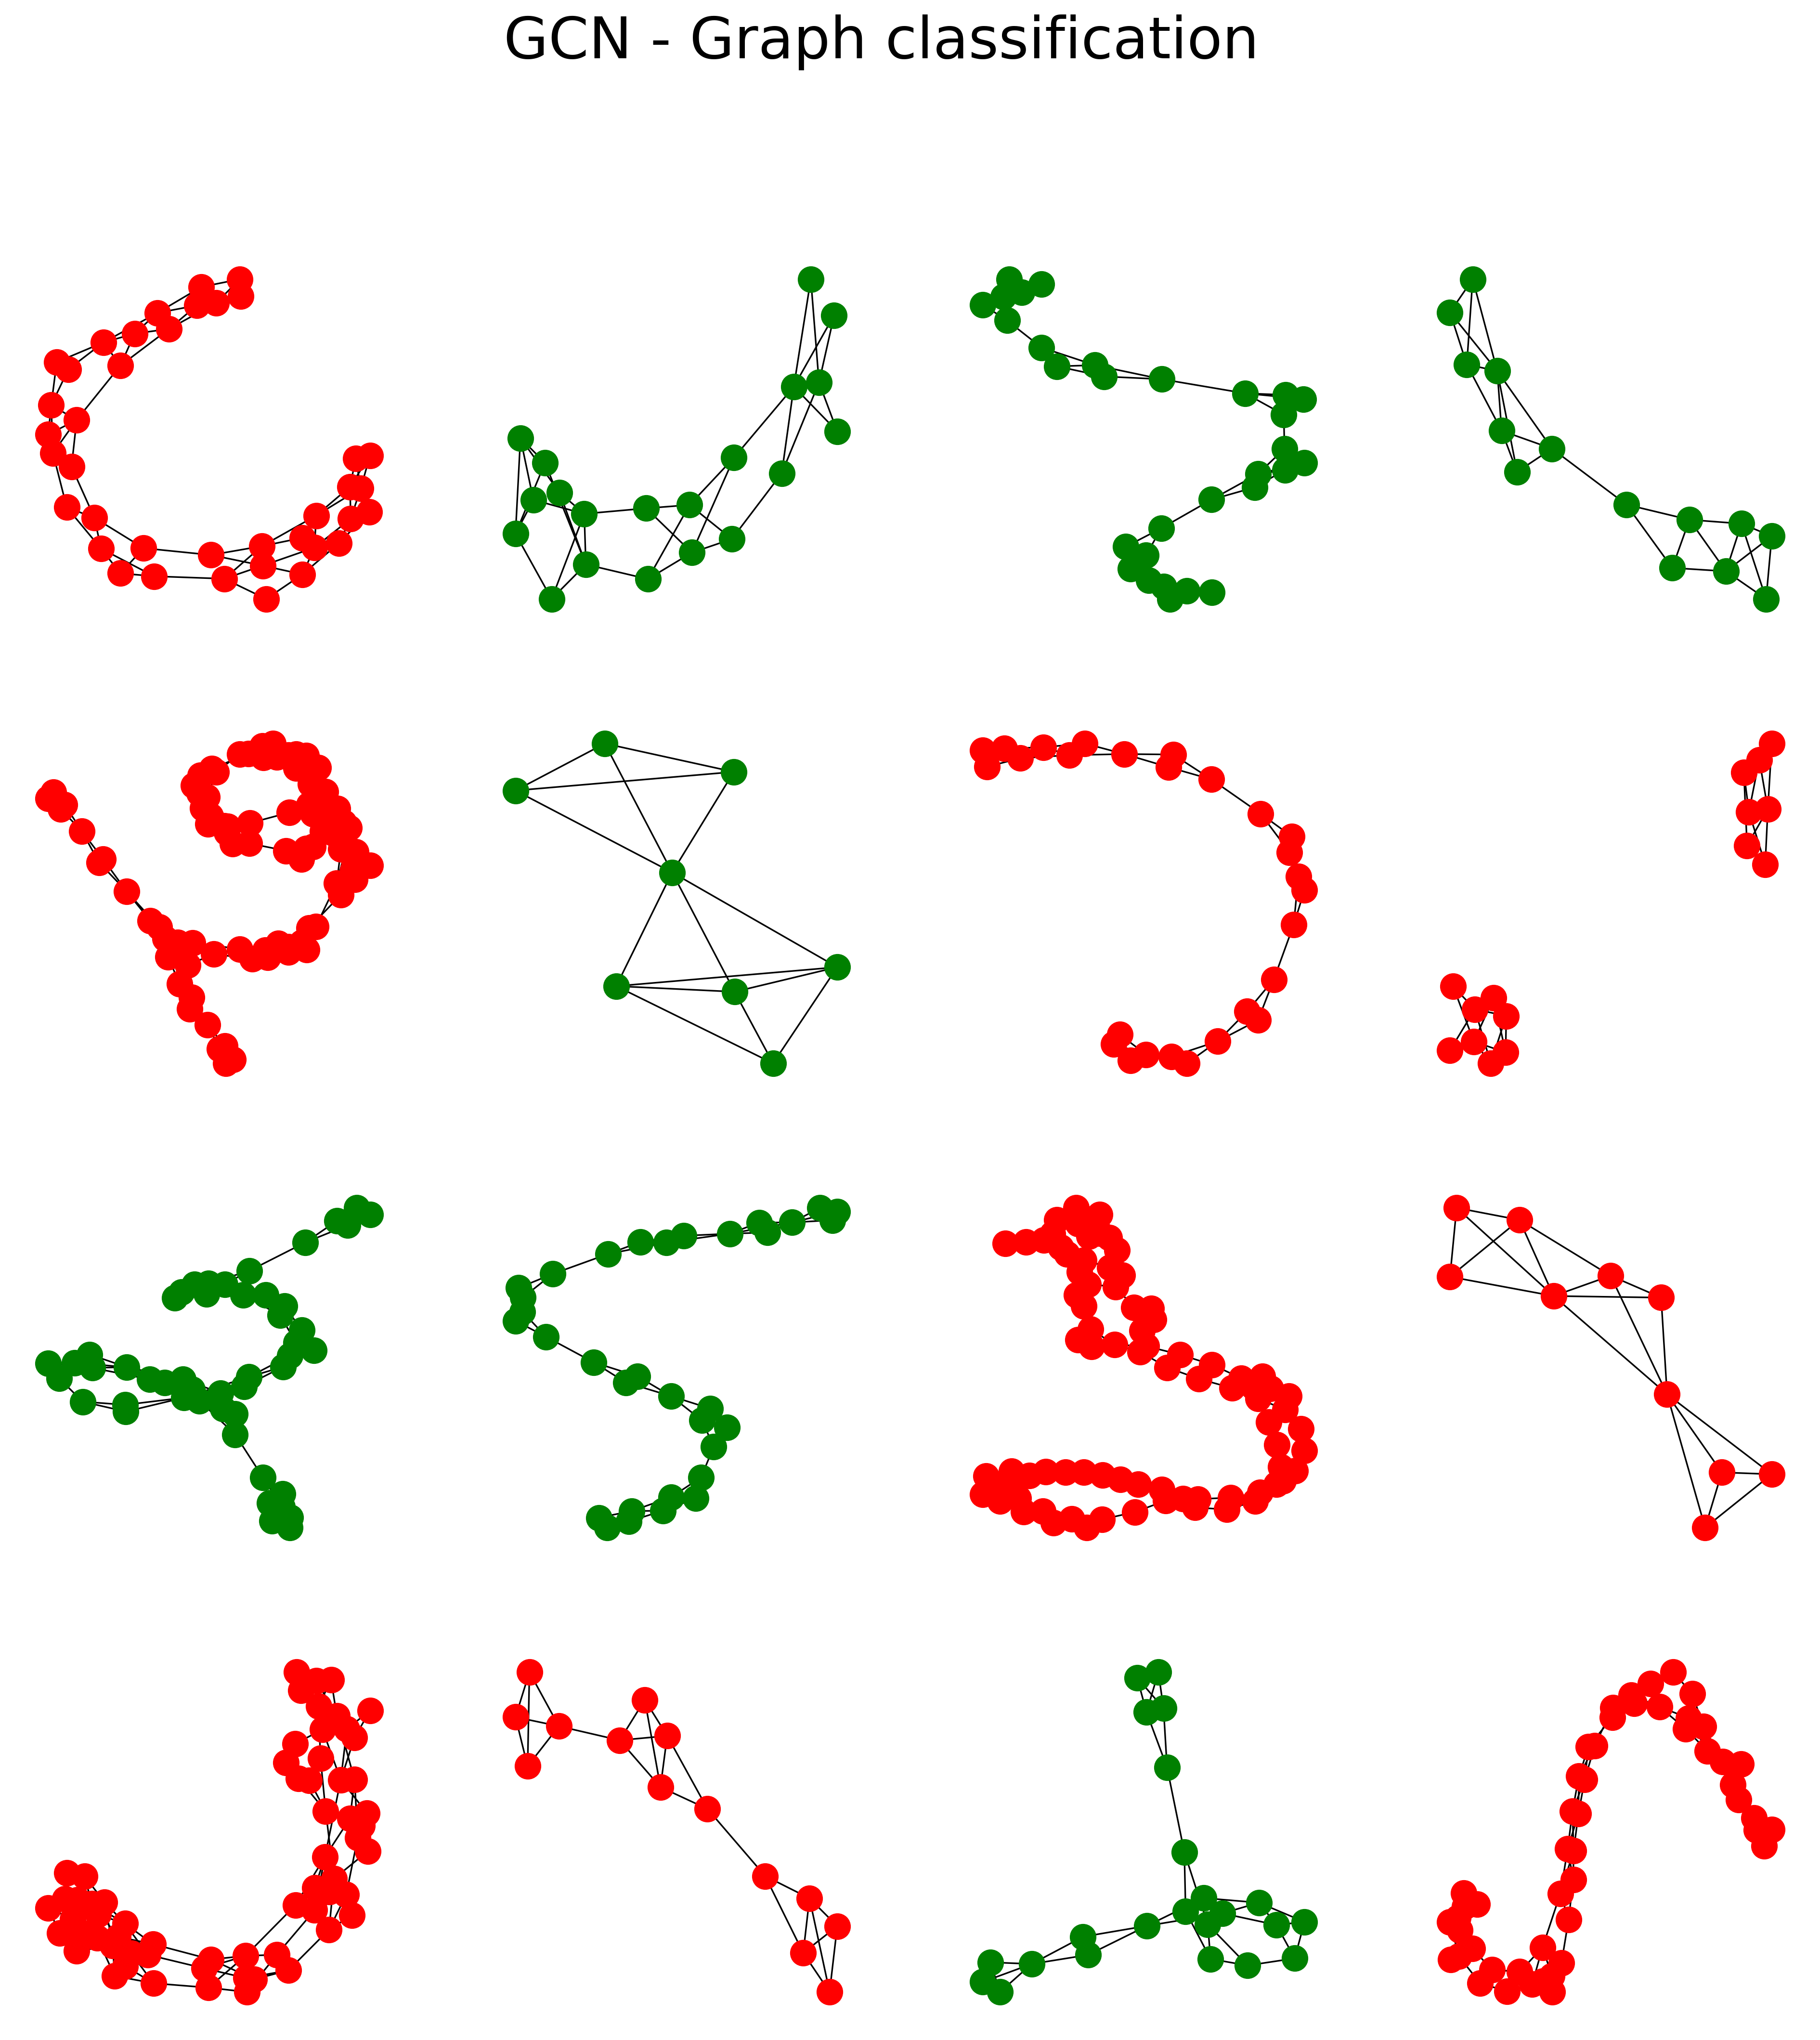

In [7]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GCN - Graph classification')
for i, data in enumerate(dataset[1113-16:]):
      # Calculate color (green if correct, red otherwise)
      _, out = gcn(data.x, data.edge_index, data.batch)
      color = "green" if out.argmax(dim=1) == data.y else "red"
      # Plot graph
      ix = np.unravel_index(i, ax.shape)
      ax[ix].axis('off')
      G = to_networkx(dataset[i], to_undirected=True)
      nx.draw_networkx(G,
                       pos=nx.spring_layout(G, seed=0),
                       with_labels=False,
                       node_size=150,
                       node_color=color,
                       width=0.8,
                       ax=ax[ix]
                       )

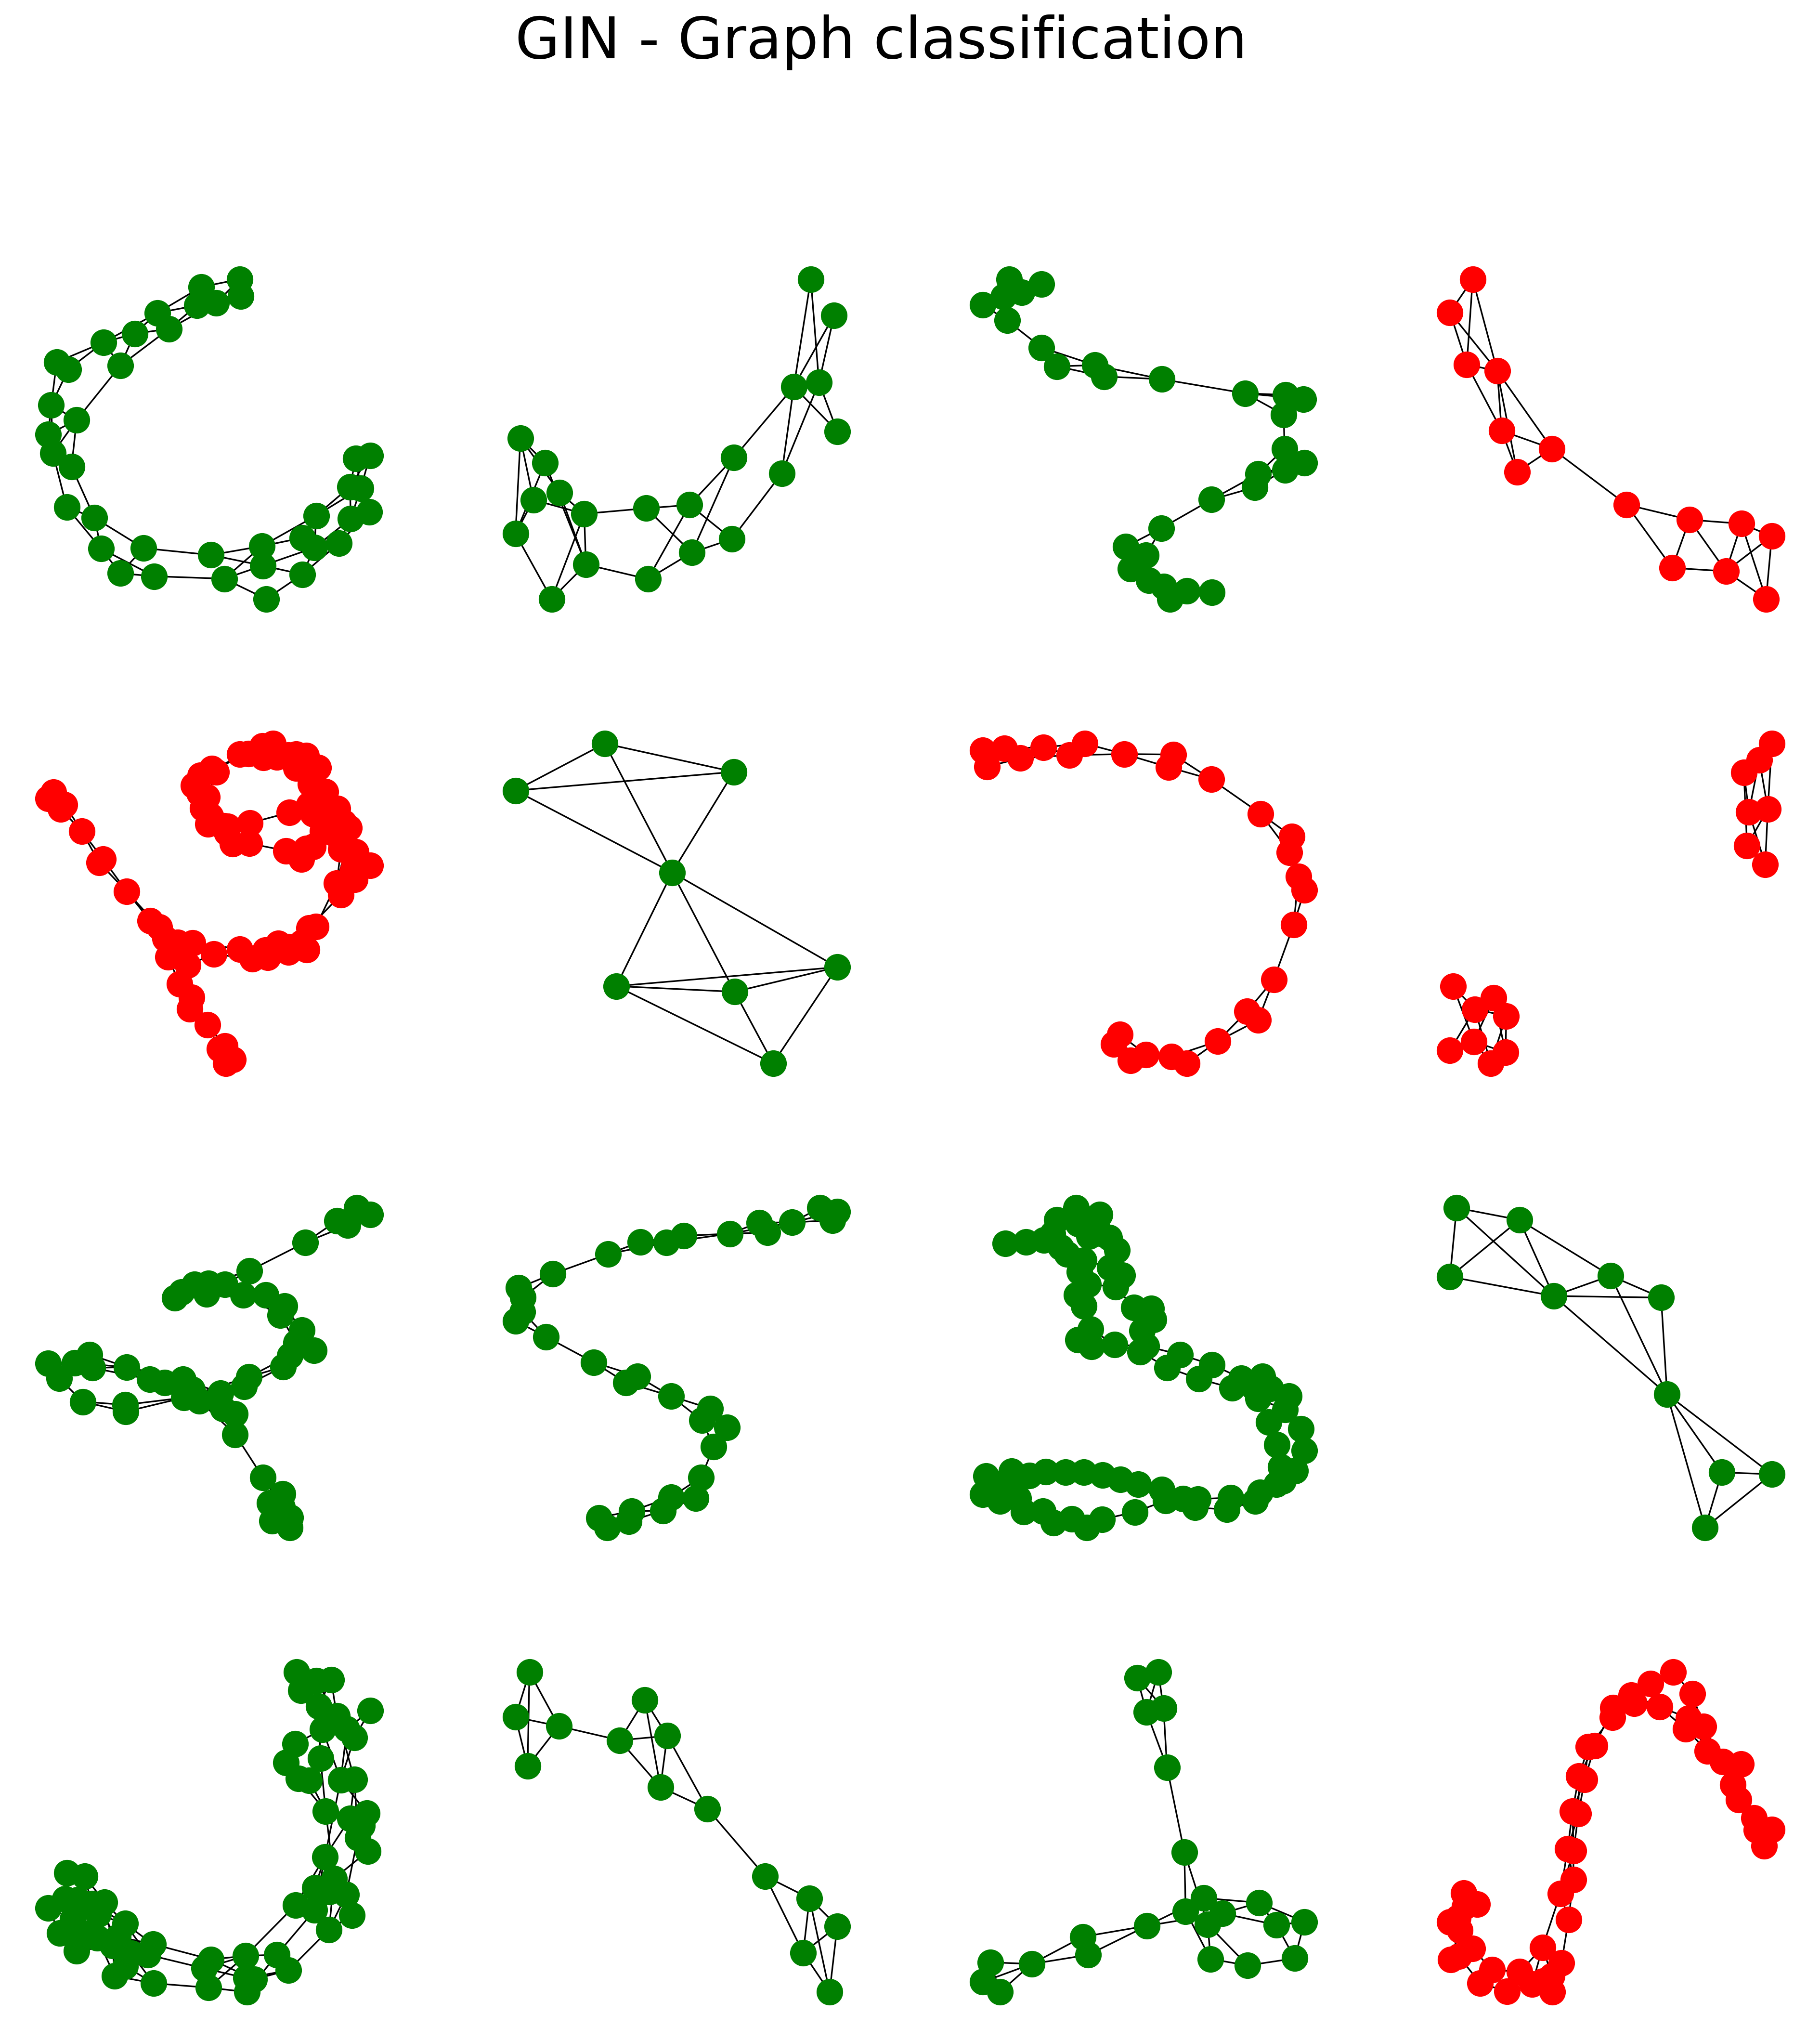

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )


Como vemos los modelos GCN y GIN cometen errores diferentes.


Vamos a aprovechar esto creando un conjunto.

In [11]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc = 0

for data in test_loader:
    # Get classifications
    _, out_gcn = gcn(data.x, data.edge_index, data.batch)
    _, out_gin = gin(data.x, data.edge_index, data.batch)
    out = (out_gcn + out_gin)/2

    # Calculate accuracy scores
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc += accuracy(out.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc*100:.2f}%')

GCN accuracy:     57.03%
GIN accuracy:     72.92%
GCN+GIN accuracy: 73.44%
